<a href="https://colab.research.google.com/github/iHev10/Object-Localization-from-scratch/blob/main/Object_Localization_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
# import libraries
from glob import glob
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skimage.transform import resize

import cv2

import tensorflow as tf
import keras

from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Flatten, Concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import binary_crossentropy, categorical_crossentropy

# Identify actual boxes

In [ ]:
def data_generator(batch_size=64):
  # generate data
  while True:

    for _ in range(50):
      # generate images and targets
      x = np.zeros((batch_size, 100, 100, 3))
      y = np.zeros((batch_size, 4))

      for n in range(batch_size):
        # make random boxes and store their locations
        row_0 = np.random.randint(0, 90)
        col_0 = np.random.randint(0, 90)
        row_1 = np.random.randint(row_0, 100)
        col_1 = np.random.randint(col_0, 100)

        x[n, row_0:row_1, col_0:col_1, :] = 1

        # normalize the cordinates
        y[n, 0] = row_0 / 100. # top row
        y[n, 1] = col_0 / 100. # left col
        y[n, 2] = (row_1 - row_0) / 100. # height
        y[n, 3] = (col_1 - col_0) / 100. # width

      yield x, y

In [ ]:
# create the model
vgg = VGG16(input_shape=(100, 100, 3), include_top=False, weights="imagenet")
x = Flatten()(vgg.output)
x = Dense(4, activation="sigmoid")(x)

model = Model(vgg.input, x)
model.compile(loss="binary_crossentropy", optimizer="adam")

In [ ]:
model.fit(data_generator(), steps_per_epoch=50, epochs=10)

Epoch 1/10
50/50 [==============================] - 14s 192ms/step - loss: 0.6056
Epoch 2/10
50/50 [==============================] - 10s 196ms/step - loss: 0.5165
Epoch 3/10
50/50 [==============================] - 10s 190ms/step - loss: 0.5098
Epoch 4/10
50/50 [==============================] - 10s 192ms/step - loss: 0.5063
Epoch 5/10
50/50 [==============================] - 9s 184ms/step - loss: 0.5057
Epoch 6/10
50/50 [==============================] - 9s 183ms/step - loss: 0.5074
Epoch 7/10
50/50 [==============================] - 9s 184ms/step - loss: 0.5051
Epoch 8/10
50/50 [==============================] - 9s 188ms/step - loss: 0.5036
Epoch 9/10
50/50 [==============================] - 9s 186ms/step - loss: 0.5046
Epoch 10/10
50/50 [==============================] - 9s 186ms/step - loss: 0.5022


In [ ]:
def plot_predictions():
  # generate a random image
  img = np.zeros((100, 100, 3))
  row_0 = np.random.randint(0, 90)
  col_0 = np.random.randint(0, 90)
  row_1 = np.random.randint(row_0, 100)
  col_1 = np.random.randint(col_0, 100)

  img[row_0:row_1, col_0:col_1, :] = 1

  # make predictions
  x = np.expand_dims(img, 0)
  x_0, y_0, h, w = model.predict(x)[0]

  x_0 =int(x_0 * 100)
  y_0 = int(y_0 * 100)
  h = int(h * 100)
  w = int(w * 100)

  print(x_0, y_0, h, w)
  # draw the box
  cv2.rectangle(img, (y_0, x_0), (y_0 + w, x_0 + h), color=(255, 0, 0))
  plt.imshow(img)
  plt.title("predicted boxes")


1/1 [==============================] - 0s 19ms/step


27 66 62 15


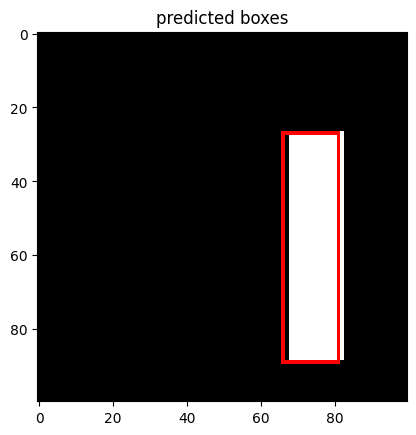

In [ ]:
plot_predictions()

# Locate an actual object

In [ ]:
# download a target image
!wget -nc https://lazyprogrammer.me/course_files/charmander-tight.png

--2024-02-08 19:45:12--  https://lazyprogrammer.me/course_files/charmander-tight.png
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3952 (3.9K) [image/png]
Saving to: ‘charmander-tight.png’

charmander-tight.pn 100%[===================>]   3.86K  --.-KB/s    in 0s      

2024-02-08 19:45:13 (63.8 MB/s) - ‘charmander-tight.png’ saved [3952/3952]



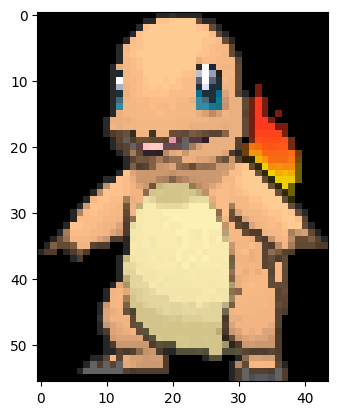

In [ ]:
# load and show the object
object_img = image.load_img("charmander-tight.png")
object_img = np.array(object_img)
plt.imshow(object_img)

In [ ]:
H, W = 300, 300 # size of full image
CH_H, CH_W = object_img.shape[:2] # size of object

def data_generator(batch_size=64, object=object_img, H=H, W=W, CH_H=CH_H, CH_W=CH_W):

  # generate data
  while True:

    for _ in range(50):
      # generate images and targets
      x = np.zeros((batch_size, H, W, 3))
      y = np.zeros((batch_size, 4))

      for n in range(batch_size):
        # make an image with an object in a random location
        row_0 = np.random.randint(0, H - CH_H)
        col_0 = np.random.randint(0, W - CH_W)
        row_1 = row_0 + CH_H
        col_1 = col_0 + CH_W

        x[n, row_0:row_1, col_0:col_1, :] = object[:, :, :3]

        # normalize the cordinates
        y[n, 0] = row_0 / H # top row
        y[n, 1] = col_0 / W # left col
        y[n, 2] = CH_H / H # height
        y[n, 3] = CH_W / W # width

      yield x, y

In [ ]:
# create the model
vgg = VGG16(input_shape=(H, W, 3), include_top=False, weights="imagenet")
x = Flatten()(vgg.output)
x = Dense(4, activation="sigmoid")(x)

model = Model(vgg.input, x)
model.compile(loss="binary_crossentropy", optimizer="adam")

In [ ]:
model.fit(data_generator(), steps_per_epoch=50, epochs=5)

Epoch 1/5
50/50 [==============================] - 78s 1s/step - loss: 0.8463
Epoch 2/5
50/50 [==============================] - 74s 1s/step - loss: 0.4987
Epoch 3/5
50/50 [==============================] - 74s 1s/step - loss: 0.4971
Epoch 4/5
50/50 [==============================] - 74s 1s/step - loss: 0.4971
Epoch 5/5
50/50 [==============================] - 74s 1s/step - loss: 0.4979


In [ ]:
def plot_predictions(object=object_img):
  # generate a random image
  img = np.zeros((H, W, 3))
  row_0 = np.random.randint(0, H - CH_H)
  col_0 = np.random.randint(0, W - CH_W)
  row_1 = row_0 + CH_H
  col_1 = col_0 + CH_W

  img[row_0:row_1, col_0:col_1, :] = object[:, :, :3]

  # make predictions
  x = np.expand_dims(img, 0)
  x_0, y_0, h, w = model.predict(x)[0]

  x_0 =int(x_0 * H)
  y_0 = int(y_0 * W)
  x_1 = int(x_0 + h * H)
  y_1 = int(y_0 + w * W)

  print("true location: ", row_0, col_0, row_1, col_1)
  print("preds: ", x_0, y_0, x_1, y_1)
  # draw the box
  cv2.rectangle(img, (y_0, x_0), (y_1, x_1), color=(255, 0, 0))
  plt.imshow(img.astype(np.uint8))
  plt.title("predicted location")
  plt.show()

1/1 [==============================] - 0s 26ms/step
true location:  72 129 128 173
preds:  71 129 127 172


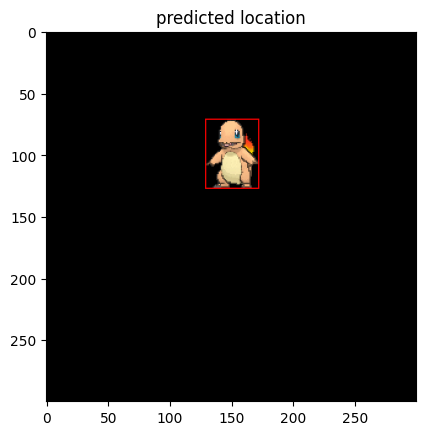

In [ ]:
plot_predictions()

# Different size objects

In [ ]:
# download a target image
!wget -nc https://lazyprogrammer.me/course_files/charmander-tight.png

--2024-02-09 10:11:23--  https://lazyprogrammer.me/course_files/charmander-tight.png
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3952 (3.9K) [image/png]
Saving to: ‘charmander-tight.png’

charmander-tight.pn 100%[===================>]   3.86K  --.-KB/s    in 0s      

2024-02-09 10:11:24 (75.8 MB/s) - ‘charmander-tight.png’ saved [3952/3952]



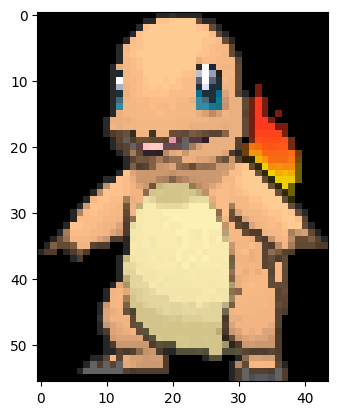

In [ ]:
# load and show the object
object_img = image.load_img("charmander-tight.png")
object_img = np.array(object_img)
plt.imshow(object_img)

In [ ]:
H, W = 200, 200 # size of full image
CH_H, CH_W = object_img.shape[:2] # size of object

def data_generator_with_resize(batch_size=64, object=object_img, H=H, W=W, CH_H=CH_H, CH_W=CH_W):

  # generate data
  while True:

    for _ in range(50):
      # generate images and targets
      x = np.zeros((batch_size, H, W, 3))
      y = np.zeros((batch_size, 4))

      for n in range(batch_size):
        # randomly select scale factore
        scale = 0.5 + np.random.random() # [0.5, 1.5]
        # calculate new height and width
        new_h, new_w = int(scale * CH_H), int(scale * CH_W)
        # resize object
        resized_object = resize(object, (new_h, new_w), preserve_range=True).astype(np.uint8)

        # make an image with an object in a random location
        row_0 = np.random.randint(0, H - new_h)
        col_0 = np.random.randint(0, W - new_w)
        row_1 = row_0 + new_h
        col_1 = col_0 + new_w

        x[n, row_0:row_1, col_0:col_1, :] = resized_object[:, :, :3]

        # normalize the cordinates
        y[n, 0] = row_0 / H # top row
        y[n, 1] = col_0 / W # left col
        y[n, 2] = (row_1 - row_0) / H # height
        y[n, 3] = (col_1 - col_0) / W # width

      yield x/255., y

In [ ]:
# create the model
vgg = VGG16(input_shape=(H, W, 3), include_top=False, weights="imagenet")
x = Flatten()(vgg.output)
x = Dense(4, activation="sigmoid")(x)

model = Model(vgg.input, x)
model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001))

58889256/58889256 [==============================] - 1s 0us/step


In [ ]:
model.fit(data_generator_with_resize(), steps_per_epoch=50, epochs=5)

Epoch 1/5
50/50 [==============================] - 63s 588ms/step - loss: 0.9546
Epoch 2/5
50/50 [==============================] - 30s 595ms/step - loss: 0.5507
Epoch 3/5
50/50 [==============================] - 30s 606ms/step - loss: 0.5473
Epoch 4/5
50/50 [==============================] - 31s 614ms/step - loss: 0.5454
Epoch 5/5
50/50 [==============================] - 31s 619ms/step - loss: 0.5445


In [ ]:
def plot_predictions_with_resize(object=object_img):
  # randomly select scale factore
  scale = 0.5 + np.random.random() # [0.5, 1.5]
  # calculate new height and width
  new_h, new_w = int(scale * CH_H), int(scale * CH_W)
  # resize object
  resized_object = resize(object, (new_h, new_w), preserve_range=True).astype(np.uint8)

  # generate a random image
  img = np.zeros((H, W, 3))
  row_0 = np.random.randint(0, H - new_h)
  col_0 = np.random.randint(0, W - new_w)
  row_1 = row_0 + new_h
  col_1 = col_0 + new_w

  img[row_0:row_1, col_0:col_1, :] = resized_object[:, :, :3]

  # make predictions
  x = np.expand_dims(img, 0) / 255.
  x_0, y_0, h, w = model.predict(x)[0]

  x_0 =int(x_0 * H)
  y_0 = int(y_0 * W)
  x_1 = int(x_0 + h * H)
  y_1 = int(y_0 + w * W)

  print("true location: ", row_0, col_0, row_1, col_1)
  print("preds: ", x_0, y_0, x_1, y_1)
  # draw the box
  cv2.rectangle(img, (y_0, x_0), (y_1, x_1), color=(255, 0, 0))
  plt.imshow(img.astype(np.uint8))
  plt.title("predicted location")
  plt.show()

1/1 [==============================] - 0s 20ms/step
true location:  111 73 153 106
preds:  112 73 152 105


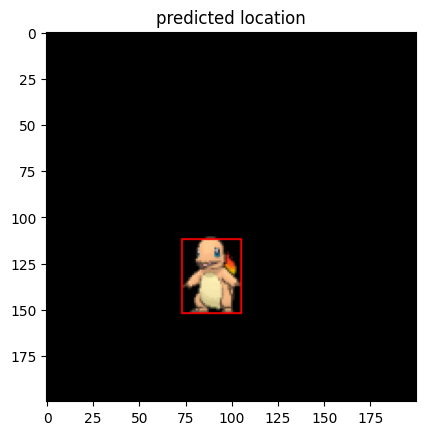

In [ ]:
plot_predictions_with_resize()

# Flipped objects

In [ ]:
# download a target image
!wget -nc https://lazyprogrammer.me/course_files/charmander-tight.png

--2024-02-09 17:55:25--  https://lazyprogrammer.me/course_files/charmander-tight.png
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3952 (3.9K) [image/png]
Saving to: ‘charmander-tight.png’

charmander-tight.pn 100%[===================>]   3.86K  --.-KB/s    in 0s      

2024-02-09 17:55:25 (65.2 MB/s) - ‘charmander-tight.png’ saved [3952/3952]



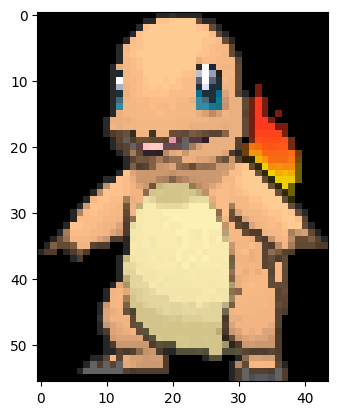

In [ ]:
# load and show the object
object_img = image.load_img("charmander-tight.png")
object_img = np.array(object_img)
plt.imshow(object_img)

In [ ]:
H, W = 200, 200 # size of full image
CH_H, CH_W = object_img.shape[:2] # size of object

def data_generator_flipped(batch_size=64, object=object_img, H=H, W=W, CH_H=CH_H, CH_W=CH_W):

  # generate data
  while True:

    for _ in range(50):
      # generate images and targets
      x = np.zeros((batch_size, H, W, 3))
      y = np.zeros((batch_size, 4))

      for n in range(batch_size):
        # randomly select scale factore
        scale = 0.5 + np.random.random() # [0.5, 1.5]
        # calculate new height and width
        new_h, new_w = int(scale * CH_H), int(scale * CH_W)
        # resize object
        resized_object = resize(object, (new_h, new_w), preserve_range=True).astype(np.uint8)

        # make an image with an object in a random location
        row_0 = np.random.randint(0, H - new_h)
        col_0 = np.random.randint(0, W - new_w)
        row_1 = row_0 + new_h
        col_1 = col_0 + new_w

        # flip object
        if np.random.random() < 0.5:
          obj = np.fliplr(resized_object)
        else:
          obj = resized_object

        x[n, row_0:row_1, col_0:col_1, :] = obj[:, :, :3]

        # normalize the cordinates
        y[n, 0] = row_0 / H # top row
        y[n, 1] = col_0 / W # left col
        y[n, 2] = (row_1 - row_0) / H # height
        y[n, 3] = (col_1 - col_0) / W # width

      yield x/255., y

In [ ]:
# create the model
vgg = VGG16(input_shape=(H, W, 3), include_top=False, weights="imagenet")
x = Flatten()(vgg.output)
x = Dense(4, activation="sigmoid")(x)

model = Model(vgg.input, x)
model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.0001))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
model.fit(data_generator_flipped(), steps_per_epoch=50, epochs=5)

Epoch 1/5
50/50 [==============================] - 68s 662ms/step - loss: 0.5523
Epoch 2/5
50/50 [==============================] - 33s 650ms/step - loss: 0.5448
Epoch 3/5
50/50 [==============================] - 33s 654ms/step - loss: 0.5445
Epoch 4/5
50/50 [==============================] - 33s 655ms/step - loss: 0.5458
Epoch 5/5
50/50 [==============================] - 33s 651ms/step - loss: 0.5423


In [ ]:
def plot_predictions_flipped(object=object_img):
  # randomly select scale factore
  scale = 0.5 + np.random.random() # [0.5, 1.5]
  # calculate new height and width
  new_h, new_w = int(scale * CH_H), int(scale * CH_W)
  # resize object
  resized_object = resize(object, (new_h, new_w), preserve_range=True).astype(np.uint8)

  # generate a random image
  img = np.zeros((H, W, 3))
  row_0 = np.random.randint(0, H - new_h)
  col_0 = np.random.randint(0, W - new_w)
  row_1 = row_0 + new_h
  col_1 = col_0 + new_w

  # flip object
  if np.random.random() < 0.5:
    obj = np.fliplr(resized_object)
  else:
    obj = resized_object

  img[row_0:row_1, col_0:col_1, :] = obj[:, :, :3]

  # make predictions
  x = np.expand_dims(img, 0) / 255.
  x_0, y_0, h, w = model.predict(x)[0]

  x_0 =int(x_0 * H)
  y_0 = int(y_0 * W)
  x_1 = int(x_0 + h * H)
  y_1 = int(y_0 + w * W)

  print("true location: ", row_0, col_0, row_1, col_1)
  print("preds: ", x_0, y_0, x_1, y_1)
  # draw the box
  cv2.rectangle(img, (y_0, x_0), (y_1, x_1), color=(255, 0, 0))
  plt.imshow(img.astype(np.uint8))
  plt.title("predicted location")
  plt.show()

1/1 [==============================] - 0s 19ms/step
true location:  32 46 79 83
preds:  33 46 78 83


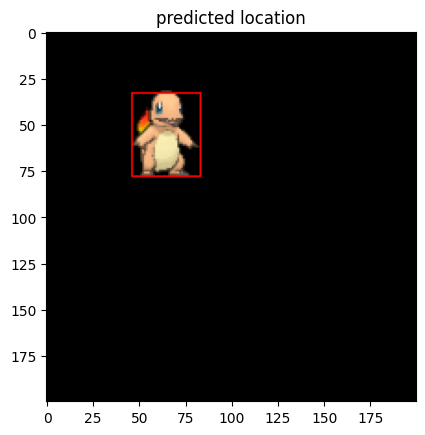

In [ ]:
plot_predictions_flipped()

# Add actual background

In [ ]:
# download a target image
!wget -nc https://lazyprogrammer.me/course_files/charmander-tight.png
!wget http://dags.stanford.edu/data/iccv09Data.tar.gz
!tar -xvf iccv09Data.tar.gz

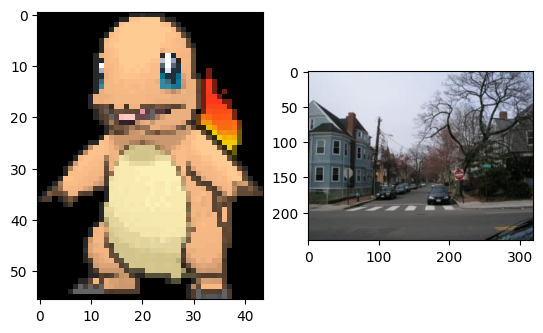

In [ ]:
# load and show the object and the background
bg_paths = glob("iccv09Data/images/*.jp*g")

object_img = image.load_img("charmander-tight.png")
object_img = np.array(object_img)
bg_img = image.load_img(bg_paths[0])
bg_img = np.array(bg_img)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(object_img)
ax[1].imshow(bg_img)

In [ ]:
H, W = 200, 200 # size of full image
CH_H, CH_W = object_img.shape[:2] # size of object

# resize the background
bg_resized = resize(bg_img, (H, W), preserve_range=True).astype(np.uint8)

def data_generator_bg(batch_size=64, object=object_img, H=H, W=W, CH_H=CH_H, CH_W=CH_W):

  # generate data
  while True:

    for _ in range(50):
      # generate images and targets
      x = np.zeros((batch_size, H, W, 3))
      y = np.zeros((batch_size, 4))

      for n in range(batch_size):
        # choose a random background
        bg = image.load_img(bg_paths[np.random.choice(len(bg_paths))])
        bg =  np.array(bg).copy()
        bg_h, bg_w = bg.shape[:2]

        # dimensions must greeter than H,W
        if bg_w <= W or bg_h <= H:
          continue

        rnd_h = np.random.randint(bg_h - H)
        rnd_w = np.random.randint(bg_w - W)
        bg = bg[rnd_h:rnd_h + H, rnd_w:rnd_w + W]

        # randomly select scale factore
        scale = 0.5 + np.random.random() # [0.5, 1.5]
        # calculate new height and width
        new_h, new_w = int(scale * CH_H), int(scale * CH_W)
        # resize object
        resized_object = resize(object, (new_h, new_w), preserve_range=True).astype(np.uint8)

        # make an image with an object in a random location
        row_0 = np.random.randint(0, H - new_h)
        col_0 = np.random.randint(0, W - new_w)
        row_1 = row_0 + new_h
        col_1 = col_0 + new_w

        # flip object
        if np.random.random() < 0.5:
          obj = np.fliplr(resized_object)
        else:
          obj = resized_object

        # where should background be
        mask = (obj[:, :, :3] == 0)

        # relvant part of background
        bg_slice = bg[row_0:row_1, col_0:col_1, :]

        # add object to the background
        bg[row_0:row_1, col_0:col_1, :] = (bg_slice * mask) + obj
        x[n,::] = bg

        # normalize the cordinates
        y[n, 0] = row_0 / H # top row
        y[n, 1] = col_0 / W # left col
        y[n, 2] = (row_1 - row_0) / H # height
        y[n, 3] = (col_1 - col_0) / W # width

      yield x/255., y

In [ ]:
# create the model
vgg = VGG16(input_shape=(H, W, 3), include_top=False, weights="imagenet")
x = Flatten()(vgg.output)
x = Dense(4, activation="sigmoid")(x)

model = Model(vgg.input, x)
model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.0001))

In [ ]:
model.fit(data_generator_bg(), steps_per_epoch=50, epochs=5)

Epoch 1/5
50/50 [==============================] - 35s 632ms/step - loss: 0.5670
Epoch 2/5
50/50 [==============================] - 32s 647ms/step - loss: 0.5392
Epoch 3/5
50/50 [==============================] - 33s 655ms/step - loss: 0.5355
Epoch 4/5
50/50 [==============================] - 33s 666ms/step - loss: 0.5370
Epoch 5/5
50/50 [==============================] - 34s 676ms/step - loss: 0.5362


In [ ]:
def plot_predictions_bg(object=object_img):
  # choose a random background
  bg = image.load_img(bg_paths[np.random.choice(len(bg_paths))])
  bg =  np.array(bg).copy()
  bg_h, bg_w = bg.shape[:2]

  # dimensions must greeter than H, W
  if bg_w <= W or bg_h <= H:
    rnd_h, rnd_w =0, 0
  else:
    rnd_h = np.random.randint(bg_h - H)
    rnd_w = np.random.randint(bg_w - W)

  bg = bg[rnd_h:rnd_h + H, rnd_w:rnd_w + W]

  # randomly select scale factore
  scale = 0.5 + np.random.random() # [0.5, 1.5]
  # calculate new height and width
  new_h, new_w = int(scale * CH_H), int(scale * CH_W)
  # resize object
  resized_object = resize(object_img, (new_h, new_w), preserve_range=True).astype(np.uint8)

  # make an image with an object in a random location
  row_0 = np.random.randint(0, H - new_h)
  col_0 = np.random.randint(0, W - new_w)
  row_1 = row_0 + new_h
  col_1 = col_0 + new_w

  # flip object
  if np.random.random() < 0.5:
    obj = np.fliplr(resized_object)
  else:
    obj = resized_object

  # where should background be
  mask = (obj[:, :, :3] == 0)

  # relvant part of background
  bg_slice = bg[row_0:row_1, col_0:col_1, :]

  # add object to the background
  bg[row_0:row_1, col_0:col_1, :] = (bg_slice * mask) + obj

  # make predictions
  x = np.expand_dims(bg, 0) / 255.
  x_0, y_0, h, w = model.predict(x)[0]

  x_0 =int(x_0 * H)
  y_0 = int(y_0 * W)
  x_1 = int(x_0 + h * H)
  y_1 = int(y_0 + w * W)

  print("true location: ", row_0, col_0, row_1, col_1)
  print("preds: ", x_0, y_0, x_1, y_1)
  # draw the box
  cv2.rectangle(bg, (y_0, x_0), (y_1, x_1), color=(255, 0, 0))
  plt.imshow(bg.astype(np.uint8))
  plt.title("predicted location")
  plt.show()

1/1 [==============================] - 0s 18ms/step
true location:  133 133 183 172
preds:  133 131 181 169


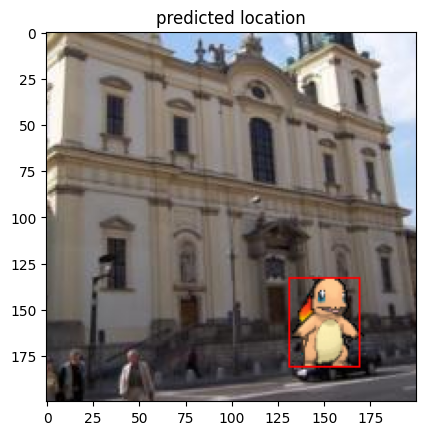

In [ ]:
plot_predictions_bg()


# Object may not appear

In [ ]:
# download a target image
!wget -nc https://lazyprogrammer.me/course_files/charmander-tight.png
!wget http://dags.stanford.edu/data/iccv09Data.tar.gz
!tar -xvf iccv09Data.tar.gz

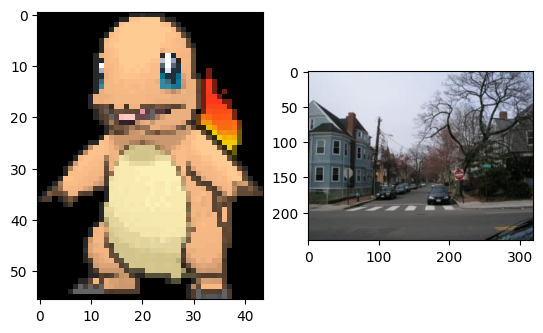

In [ ]:
# load and show the object and the background
bg_paths = glob("iccv09Data/images/*.jp*g")

object_img = image.load_img("charmander-tight.png")
object_img = np.array(object_img)
bg_img = image.load_img(bg_paths[0])
bg_img = np.array(bg_img)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(object_img)
ax[1].imshow(bg_img)

In [ ]:
H, W = 200, 200 # size of full image
CH_H, CH_W = object_img.shape[:2] # size of object
alpha = 0.5 # Object appearing factor

# resize the background
bg_resized = resize(bg_img, (H, W), preserve_range=True).astype(np.uint8)

def data_generator_bg(batch_size=64, object=object_img, H=H, W=W, CH_H=CH_H, CH_W=CH_W):

  # generate data
  while True:

    for _ in range(50):
      # generate images and targets
      x = np.zeros((batch_size, H, W, 3))
      y = np.zeros((batch_size, 5))

      for n in range(batch_size):
        # choose a random background
        bg = image.load_img(bg_paths[np.random.choice(len(bg_paths))])
        bg =  np.array(bg).copy()
        bg_h, bg_w = bg.shape[:2]

        # dimensions must greeter than H,W
        if bg_w <= W or bg_h <= H:
          continue

        rnd_h = np.random.randint(bg_h - H)
        rnd_w = np.random.randint(bg_w - W)
        bg = bg[rnd_h:rnd_h + H, rnd_w:rnd_w + W]

        if np.random.random() > alpha:
          # randomly select scale factore
          scale = 0.5 + np.random.random() # [0.5, 1.5]
          # calculate new height and width
          new_h, new_w = int(scale * CH_H), int(scale * CH_W)
          # resize object
          resized_object = resize(object, (new_h, new_w), preserve_range=True).astype(np.uint8)

          # make an image with an object in a random location
          row_0 = np.random.randint(0, H - new_h)
          col_0 = np.random.randint(0, W - new_w)
          row_1 = row_0 + new_h
          col_1 = col_0 + new_w

          # flip object
          if np.random.random() < 0.5:
            obj = np.fliplr(resized_object)
          else:
            obj = resized_object

          # where should background be
          mask = (obj[:, :, :3] == 0)

          # relvant part of background
          bg_slice = bg[row_0:row_1, col_0:col_1, :]

          # add object to the background
          bg[row_0:row_1, col_0:col_1, :] = (bg_slice * mask) + obj

          # normalize the cordinates
          y[n, 0] = row_0 / H # top row
          y[n, 1] = col_0 / W # left col
          y[n, 2] = (row_1 - row_0) / H # height
          y[n, 3] = (col_1 - col_0) / W # width
          y[n, 4] = 1 # object is in the image

        else:
          y[n, 4] = 0 # object is not in the image

        x[n,::] = bg

      yield x/255., y

In [ ]:
# make a custom loss function
def custom_loss(y_true, y_pred):
  detection_loss = binary_crossentropy(y_true[:, -1], y_pred[:, -1])
  bb_loss = binary_crossentropy(y_true[:, :-1], y_pred[:, :-1]) # Bounding Box loss
  return 2 * bb_loss * y_true[:, -1] + 0.5 * detection_loss

In [ ]:
# create the model
vgg = VGG16(input_shape=(H, W, 3), include_top=False, weights="imagenet")
x = Flatten()(vgg.output)
x = Dense(5, activation="sigmoid")(x)

model = Model(vgg.input, x)
model.compile(loss=custom_loss, optimizer=Adam(learning_rate=0.0001))

In [ ]:
model.fit(data_generator_bg(), steps_per_epoch=50, epochs=5)

Epoch 1/5
50/50 [==============================] - 36s 649ms/step - loss: 0.7174
Epoch 2/5
50/50 [==============================] - 33s 666ms/step - loss: 0.5405
Epoch 3/5
50/50 [==============================] - 34s 678ms/step - loss: 0.5459
Epoch 4/5
50/50 [==============================] - 35s 690ms/step - loss: 0.5412
Epoch 5/5
50/50 [==============================] - 35s 693ms/step - loss: 0.5457


In [ ]:
def plot_predictions_bg(object=object_img):
  # choose a random background
  bg = image.load_img(bg_paths[np.random.choice(len(bg_paths))])
  bg =  np.array(bg).copy()
  bg_h, bg_w = bg.shape[:2]

  # dimensions must greeter than H, W
  if bg_w <= W or bg_h <= H:
    rnd_h, rnd_w =0, 0
  else:
    rnd_h = np.random.randint(bg_h - H)
    rnd_w = np.random.randint(bg_w - W)

  bg = bg[rnd_h:rnd_h + H, rnd_w:rnd_w + W]

  appear = (np.random.random() > alpha)
  if appear:
    # randomly select scale factore
    scale = 0.5 + np.random.random() # [0.5, 1.5]
    # calculate new height and width
    new_h, new_w = int(scale * CH_H), int(scale * CH_W)
    # resize object
    resized_object = resize(object_img, (new_h, new_w), preserve_range=True).astype(np.uint8)

    # make an image with an object in a random location
    row_0 = np.random.randint(0, H - new_h)
    col_0 = np.random.randint(0, W - new_w)
    row_1 = row_0 + new_h
    col_1 = col_0 + new_w
    print("true location: ", row_0, col_0, row_1, col_1)

    # flip object
    if np.random.random() < 0.5:
      obj = np.fliplr(resized_object)
    else:
      obj = resized_object

    # where should background be
    mask = (obj[:, :, :3] == 0)

    # relvant part of background
    bg_slice = bg[row_0:row_1, col_0:col_1, :]

    # add object to the background
    bg[row_0:row_1, col_0:col_1, :] = (bg_slice * mask) + obj


  # make predictions
  x = np.expand_dims(bg, 0) / 255.
  x_0, y_0, h, w, p = model.predict(x)[0]

  if p > 0.5:
    x_0 =int(x_0 * H)
    y_0 = int(y_0 * W)
    x_1 = int(x_0 + h * H)
    y_1 = int(y_0 + w * W)
    print("preds: ", x_0, y_0, x_1, y_1)
  # draw the box
    cv2.rectangle(bg, (y_0, x_0), (y_1, x_1), color=(255, 0, 0))
    plt.title("predicted location")
  else:
    print("pred: No object!")
  plt.imshow(bg.astype(np.uint8))
  plt.show()

true location:  157 0 191 27
1/1 [==============================] - 0s 36ms/step
preds:  159 4 192 29


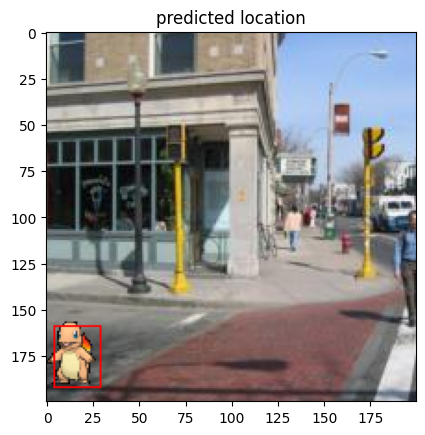

In [ ]:
plot_predictions_bg()

# Multiple classes of objects

In [ ]:
# download target images and backgrounds
!wget -nc https://lazyprogrammer.me/course_files/charmander-tight.png
!wget -nc https://lazyprogrammer.me/course_files/bulbasaur-tight.png
!wget -nc https://lazyprogrammer.me/course_files/squirtle-tight.png
!wget http://dags.stanford.edu/data/iccv09Data.tar.gz
!tar -xvf iccv09Data.tar.gz

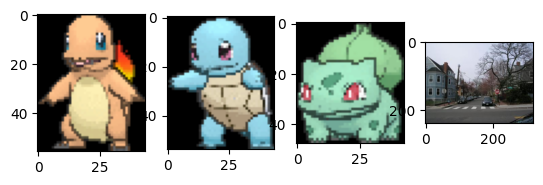

In [58]:
# load and show the object and the background
bg_paths = glob("iccv09Data/images/*.jp*g")
obj_paths = glob("*.png")
class_names = [Path(path).stem for path in obj_paths]

bg_img = image.load_img(bg_paths[0])
bg_img = np.array(bg_img)

fig, ax = plt.subplots(1, 4)
for i, path in enumerate(obj_paths):
  object_img = image.load_img(path)
  object_img = np.array(object_img)
  ax[i].imshow(object_img)
ax[3].imshow(bg_img)

In [51]:
H, W = 200, 200 # size of full image
alpha = 0.25 # Object appearing factor

# resize the background
bg_resized = resize(bg_img, (H, W), preserve_range=True).astype(np.uint8)

def data_generator_mc(batch_size=64, obj_paths=obj_paths, H=H, W=W):

  # generate data
  while True:

    for _ in range(50):
      # generate images and targets
      x = np.zeros((batch_size, H, W, 3))
      y = np.zeros((batch_size, 8))

      for n in range(batch_size):
        # choose a random background
        bg = image.load_img(bg_paths[np.random.choice(len(bg_paths))])
        bg =  np.array(bg).copy()
        bg_h, bg_w = bg.shape[:2]

        # dimensions must greeter than H,W
        if bg_w <= W or bg_h <= H:
          continue

        rnd_h = np.random.randint(bg_h - H)
        rnd_w = np.random.randint(bg_w - W)
        bg = bg[rnd_h:rnd_h + H, rnd_w:rnd_w + W]

        if np.random.random() > alpha:
          # select a random object
          obj_class = np.random.choice(len(obj_paths))
          object_img = image.load_img(obj_paths[obj_class])
          object_img = np.array(object_img)
          obj_H, obj_W = object_img.shape[:2] # size of object

          # randomly select scale factore
          scale = 0.5 + np.random.random() # [0.5, 1.5]
          # calculate new height and width
          new_h, new_w = int(scale * obj_H), int(scale * obj_W)
          # resize object
          resized_object = resize(object_img, (new_h, new_w), preserve_range=True).astype(np.uint8)

          # make an image with an object in a random location
          row_0 = np.random.randint(0, H - new_h)
          col_0 = np.random.randint(0, W - new_w)
          row_1 = row_0 + new_h
          col_1 = col_0 + new_w

          # flip object
          if np.random.random() < 0.5:
            obj = np.fliplr(resized_object)
          else:
            obj = resized_object

          # where should background be
          mask = (obj[:, :, :3] == 0)

          # relvant part of background
          bg_slice = bg[row_0:row_1, col_0:col_1, :]

          # add object to the background
          bg[row_0:row_1, col_0:col_1, :] = (bg_slice * mask) + obj

          # normalize the cordinates
          y[n, 0] = row_0 / H # top row
          y[n, 1] = col_0 / W # left col
          y[n, 2] = (row_1 - row_0) / H # height
          y[n, 3] = (col_1 - col_0) / W # width
          y[n, 4] = 1 # object is in the image
          y[n, 5 + obj_class] = 1

        else:
          y[n, 4] = 0 # object is not in the image

        x[n,::] = bg

      yield x/255., y

In [24]:
# make a custom loss function
def custom_loss_mc(y_true, y_pred):
  detection_loss = binary_crossentropy(y_true[:, 4], y_pred[:, 4])
  bb_loss = binary_crossentropy(y_true[:, :4], y_pred[:, :4]) # Bounding Box loss
  cce_loss = categorical_crossentropy(y_true[:, 5:], y_pred[:, 5:])
  return (bb_loss * y_true[:, 4]) + (cce_loss * y_true[:, 4]) + (0.5 * detection_loss)

In [25]:
# create the model
vgg = VGG16(input_shape=(H, W, 3), include_top=False, weights="imagenet")
x = Flatten()(vgg.output)
x1 = Dense(5, activation="sigmoid")(x) # bounding box + object detection
x2 = Dense(3, activation="softmax")(x) # catagories
x = Concatenate()([x1, x2])

model = Model(vgg.input, x)
model.compile(loss=custom_loss_mc, optimizer=Adam(learning_rate=0.0001))

In [26]:
model.fit(data_generator_mc(), steps_per_epoch=50, epochs=5)

Epoch 1/5
50/50 [==============================] - 36s 625ms/step - loss: 0.9885
Epoch 2/5
50/50 [==============================] - 32s 634ms/step - loss: 0.4404
Epoch 3/5
50/50 [==============================] - 32s 642ms/step - loss: 0.4128
Epoch 4/5
50/50 [==============================] - 33s 658ms/step - loss: 0.4066
Epoch 5/5
50/50 [==============================] - 33s 666ms/step - loss: 0.4088


In [62]:
def plot_predictions_mc(obj_paths=obj_paths):
  # choose a random background
  bg = image.load_img(bg_paths[np.random.choice(len(bg_paths))])
  bg =  np.array(bg).copy()
  bg_h, bg_w = bg.shape[:2]

  # dimensions must greeter than H, W
  if bg_w <= W or bg_h <= H:
    rnd_h, rnd_w =0, 0
  else:
    rnd_h = np.random.randint(bg_h - H)
    rnd_w = np.random.randint(bg_w - W)

  bg = bg[rnd_h:rnd_h + H, rnd_w:rnd_w + W]

  appear = (np.random.random() > alpha)
  if appear:
    # select a random object
    obj_class = class_names[np.random.choice(len(obj_paths))]
    object_img = image.load_img(obj_class + ".png")
    object_img = np.array(object_img)
    obj_H, obj_W = object_img.shape[:2] # size of object

    # randomly select scale factore
    scale = 0.5 + np.random.random() # [0.5, 1.5]
    # calculate new height and width
    new_h, new_w = int(scale * obj_H), int(scale * obj_W)
    # resize object
    resized_object = resize(object_img, (new_h, new_w), preserve_range=True).astype(np.uint8)

    # make an image with an object in a random location
    row_0 = np.random.randint(0, H - new_h)
    col_0 = np.random.randint(0, W - new_w)
    row_1 = row_0 + new_h
    col_1 = col_0 + new_w
    print("true location: ", row_0, col_0, row_1, col_1, obj_class)

    # flip object
    if np.random.random() < 0.5:
      obj = np.fliplr(resized_object)
    else:
      obj = resized_object

    # where should background be
    mask = (obj[:, :, :3] == 0)

    # relvant part of background
    bg_slice = bg[row_0:row_1, col_0:col_1, :]

    # add object to the background
    bg[row_0:row_1, col_0:col_1, :] = (bg_slice * mask) + obj


  # make predictions
  x = np.expand_dims(bg, 0) / 255.
  p = model.predict(x)[0]

  if p[4] > 0.5:
    x_0 =int(p[0] * H)
    y_0 = int(p[1] * W)
    x_1 = int(x_0 + p[2] * H)
    y_1 = int(y_0 + p[3] * W)

    class_pred = class_names[np.argmax(p[5:])]
    print("preds: ", x_0, y_0, x_1, y_1, class_pred)
  # draw the box
    cv2.rectangle(bg, (y_0, x_0), (y_1, x_1), color=(255, 0, 0))
    plt.title("predicted location")
  else:
    print("pred: No object!")
  plt.imshow(bg.astype(np.uint8))
  plt.show()

true location:  29 117 70 153 bulbasaur-tight
1/1 [==============================] - 0s 18ms/step
preds:  26 114 64 156 bulbasaur-tight


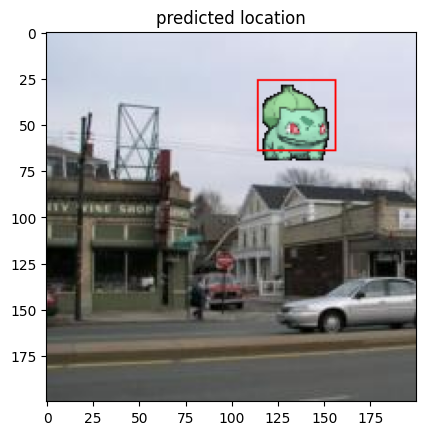

In [64]:
plot_predictions_mc()